<img src="./Pierian_Data_Logo.PNG">
<strong><center>Copyright by Pierian Data Inc.</center></strong> 
<strong><center>Created by Jose Marcial Portilla.</center></strong>

## The Data

We will be using a subset of the LendingClub DataSet obtained from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club

## NOTE: This is a special version with some extra feature engineering. You won't be able to follow along with the original file!

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

### Our Goal

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model that can predict whether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan.

The "loan_status" column contains our label.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Data Overview

In [2]:
column_info = pd.read_csv('lending_club_info.csv', index_col='LoanStatNew')
column_info.head()

,Description
LoanStatNew,
loan_amnt,The listed amount of the loan applied for by t...
term,The number of payments on the loan. Values are...
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if th...
grade,LC assigned loan grade


In [3]:
def info(col_name):
    print(column_info.loc[col_name]['Description'])

info('loan_amnt')

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


In [4]:
df = pd.read_csv('lending_club_loan_two.csv')
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [5]:
len(df)

396030

### Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

Seems like we have some missing data

In [7]:
null_columns = df.isnull().sum()
null_columns[null_columns != 0]

emp_title               22927
emp_length              18301
title                    1755
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

Later we will have to decide what to do with the missing data. We could delete the records or fill the empty fields with something.

For now, let's look at label column

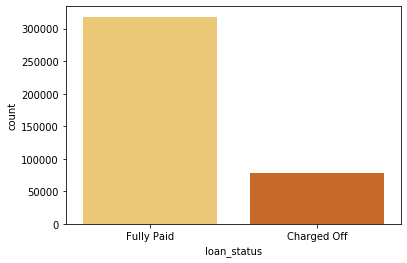

In [8]:
sns.countplot(df['loan_status'], palette="YlOrBr")

In [9]:
df['loan_status'].value_counts() * 100 / len(df)

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64

The dataset is **very** unbalanced. This means accuracy won't count as much and so we will probably want to look more into other metrics like f1 and recall.

In [10]:
df['loan_paid'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off':0})
df = df.drop('loan_status', axis=1)

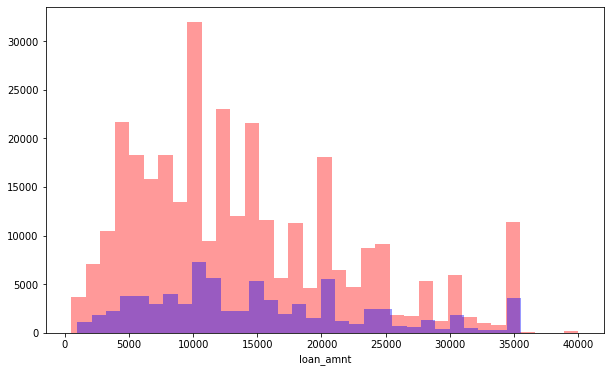

In [11]:
plt.figure(figsize=(10,6))
sns.distplot(df[df['loan_paid'] == 1]['loan_amnt'], kde=False, color="r", bins=35)
sns.distplot(df[df['loan_paid'] == 0]['loan_amnt'], kde=False, color="b", bins=35)

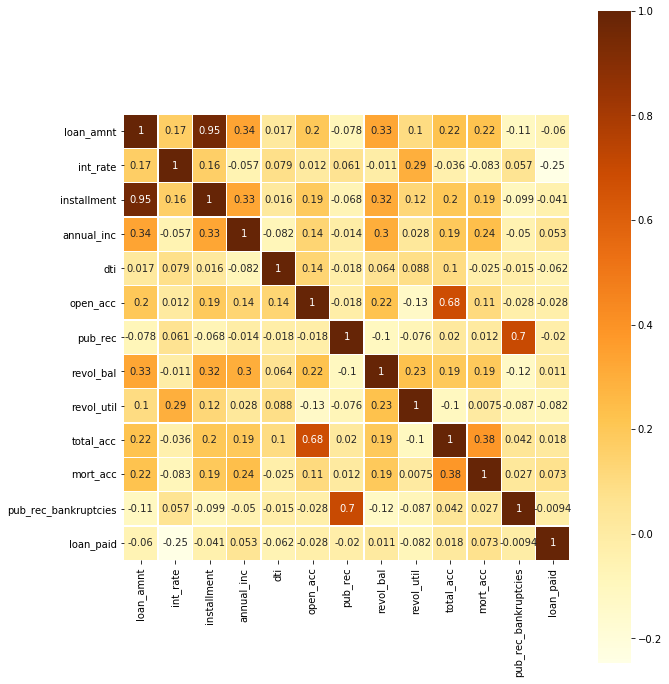

In [12]:
plt.figure(figsize=(10,12))
sns.heatmap(df.corr(), linewidths=0.3, square=True, cmap="YlOrBr", annot=True)

Installments are quite correlated to loan_amnt

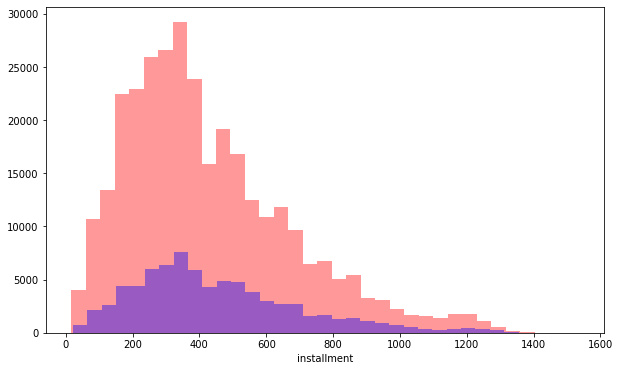

In [13]:
plt.figure(figsize=(10,6))
sns.distplot(df[df['loan_paid'] == 1]['installment'], kde=False, color="r", bins=35)
sns.distplot(df[df['loan_paid'] == 0]['installment'], kde=False, color="b", bins=35)

In [14]:
info('annual_inc')

The self-reported annual income provided by the borrower during registration.


In [15]:
df['annual_inc'].describe()

count    3.960300e+05
mean     7.420318e+04
std      6.163762e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.400000e+04
75%      9.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

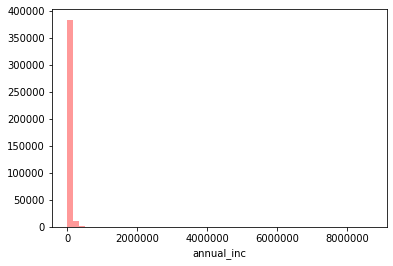

In [16]:
sns.distplot(df['annual_inc'], kde=False, color="r", bins=50)

Could this be happening because of outliers?

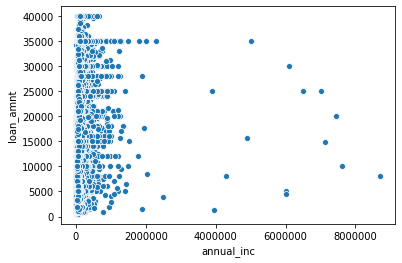

In [17]:
sns.scatterplot(df['annual_inc'],df['loan_amnt'])

In [18]:
# sum(df['annual_inc'] > 900000)
df[df['annual_inc'] > 900000]['loan_paid'].value_counts()

1    84
0    14
Name: loan_paid, dtype: int64

Could look into that as way to improve the model

## DEBT_INCOME_RATIO
### ANNUAL_INC
### TERM

### VERIFICATION STATUS

In [19]:
info('term')

The number of payments on the loan. Values are in months and can be either 36 or 60.


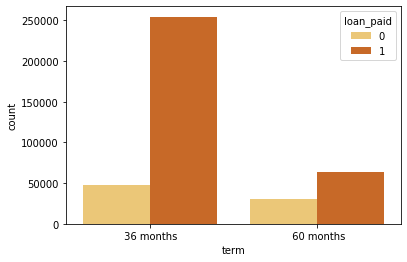

In [20]:
sns.countplot(x='term',data=df,hue='loan_paid', palette="YlOrBr")

In [21]:
df['no_payments'] = df['term'].apply(lambda x: int(x.split()[0]))
df = df.drop('term', axis=1)

In [22]:
df.head()

,loan_amnt,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_paid,no_payments
0,10000.0,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,...,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1,36
1,8000.0,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,...,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1,36
2,15600.0,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,...,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1,36
3,7200.0,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,...,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1,36
4,24375.0,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,...,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0,60


In [23]:
info('grade')

LC assigned loan grade


In [24]:
info('sub_grade')

LC assigned loan subgrade


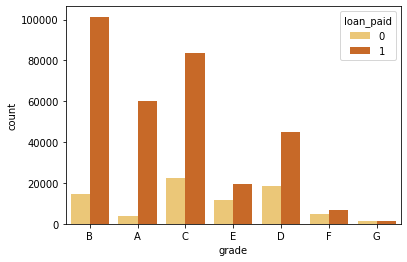

In [25]:
sns.countplot(df['grade'], hue=df['loan_paid'], palette="YlOrBr")

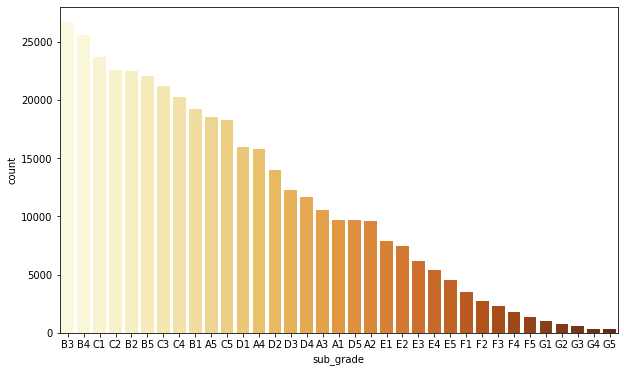

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(x='sub_grade',data=df, palette="YlOrBr",
            order=list(df['sub_grade'].value_counts().sort_values(ascending=False).index))
# list(df['sub_grade'].value_counts().sort_values(ascending=False).index)

In [27]:
df[['grade', 'sub_grade']]

,grade,sub_grade
0,B,B4
1,B,B5
2,B,B3
3,A,A2
4,C,C5
...,...,...
396025,B,B4
396026,C,C1
396027,B,B1
396028,C,C2


The 'grade' column is already part of the 'sub_grade' column, so we can get rid of it

In [28]:
df = df.drop('grade', axis=1)

In [29]:
df.head()

,loan_amnt,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_paid,no_payments
0,10000.0,11.44,329.48,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,...,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1,36
1,8000.0,11.99,265.68,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,...,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1,36
2,15600.0,10.49,506.97,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,...,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1,36
3,7200.0,6.49,220.65,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,...,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1,36
4,24375.0,17.27,609.33,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,...,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0,60


In [30]:
df['emp_title'].value_counts()

Teacher                                   4389
Manager                                   4250
Registered Nurse                          1856
RN                                        1846
Supervisor                                1830
                                          ... 
Junior financial analyst                     1
Akima                                        1
Mediation / Loss Mitigation Manager          1
New York city department of education        1
Mobile Complete, Inc.                        1
Name: emp_title, Length: 173105, dtype: int64

In [31]:
df['emp_title'].nunique()

173105

There are too many titles given to us. We could use some NLP to get some more info out of it, but for now we will drop the column

In [32]:
df = df.drop('emp_title',axis=1)

In [33]:
df['emp_length'].nunique()

11

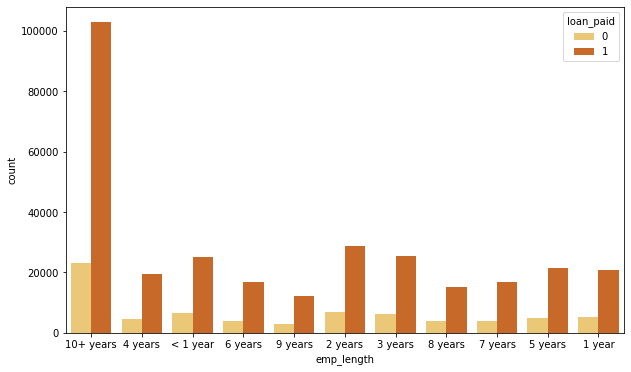

In [34]:
# There is no simple correlation between emp_length and loan_status. An important thing could be the %age of those unpaid
plt.figure(figsize=(10,6))
sns.countplot(x='emp_length',data=df,hue='loan_paid',palette="YlOrBr")

In [35]:
unpaid_group = df[df['loan_paid'] == 0].groupby('emp_length').count()['loan_amnt']
unpaid_group

emp_length
1 year        5154
10+ years    23215
2 years       6924
3 years       6182
4 years       4608
5 years       5092
6 years       3943
7 years       4055
8 years       3829
9 years       3070
< 1 year      6563
Name: loan_amnt, dtype: int64

In [36]:
df[df['loan_paid'] == 1].groupby('emp_length').count()['loan_amnt']

emp_length
1 year        20728
10+ years    102826
2 years       28903
3 years       25483
4 years       19344
5 years       21403
6 years       16898
7 years       16764
8 years       15339
9 years       12244
< 1 year      25162
Name: loan_amnt, dtype: int64

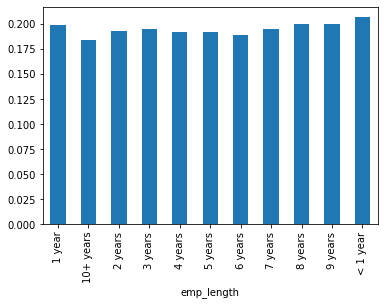

In [37]:
(unpaid_group / df.groupby('emp_length').count()['loan_amnt']).plot(kind='bar')

Looks like the percentage of those not paying is the same no matter what the emp_length so no information gained


In [38]:
df = df.drop('emp_length',axis=1)

In [39]:
df['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

Let's add 'NONE' and 'ANY' to 'OTHER' to reduce the number of categories

In [40]:
ownership = df['home_ownership'].apply(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)
ownership.value_counts()

df['home_ownership'] = ownership

In [41]:
info('verification_status')

Indicates if income was verified by LC, not verified, or if the income source was verified


In [42]:
df['verification_status'].value_counts()

Verified           139563
Source Verified    131385
Not Verified       125082
Name: verification_status, dtype: int64

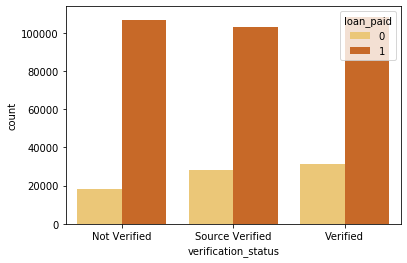

In [43]:
sns.countplot(x='verification_status', data=df, hue='loan_paid', palette="YlOrBr")

In [44]:
statuses = df['verification_status'].value_counts()
df[df['loan_paid'] == 1]['verification_status'].value_counts() / statuses

Not Verified       0.853640
Source Verified    0.785257
Verified           0.776789
Name: verification_status, dtype: float64

In [45]:
info('title')

The loan title provided by the borrower


In [46]:
df['title'].nunique()

48817

Just like the other title field, we would need some NLP to get some useful data out of this

In [47]:
df = df.drop('title',axis=1)

In [48]:
df.head()

,loan_amnt,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_paid,no_payments
0,10000.0,11.44,329.48,B4,RENT,117000.0,Not Verified,Jan-2015,vacation,26.24,...,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1,36
1,8000.0,11.99,265.68,B5,MORTGAGE,65000.0,Not Verified,Jan-2015,debt_consolidation,22.05,...,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1,36
2,15600.0,10.49,506.97,B3,RENT,43057.0,Source Verified,Jan-2015,credit_card,12.79,...,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1,36
3,7200.0,6.49,220.65,A2,RENT,54000.0,Not Verified,Nov-2014,credit_card,2.60,...,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1,36
4,24375.0,17.27,609.33,C5,MORTGAGE,55000.0,Verified,Apr-2013,credit_card,33.95,...,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0,60


In [49]:
info('issue_d')

The month which the loan was funded


This column creates data leakage. If the model is supposed to determine whether we should issue a loan, why would we pass the month in which the loan was funded?

In [50]:
df = df.drop('issue_d', axis=1)

In [51]:
df['purpose'].value_counts()

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64

In [52]:
df['purpose'].nunique()

14

In [53]:
info('earliest_cr_line')

The month the borrower's earliest reported credit line was opened


In [54]:
df['earliest_cr_line'].nunique()

684

In [55]:
month = df['earliest_cr_line'].apply(lambda x: x.split('-')[0])
year = df['earliest_cr_line'].apply(lambda x: x.split('-')[1])

df['earliest_cr_line_yr'] = year

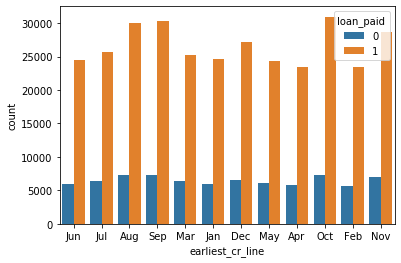

In [56]:
sns.countplot(x=month,hue=df['loan_paid'])

The ratios of fully-paid to charged-off seems similar regardless of the month, so not much information gained there

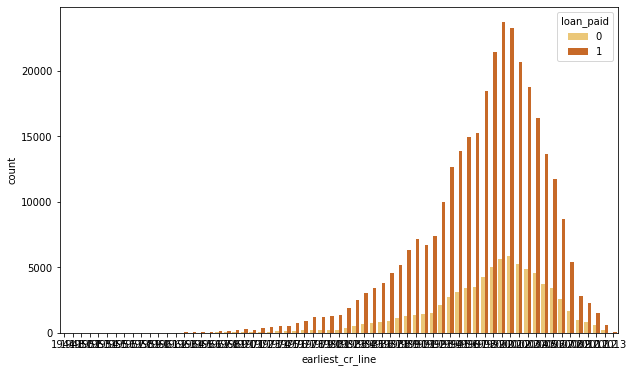

In [57]:
plt.figure(figsize=(10,6))
sns.countplot(x=year,hue=df['loan_paid'], palette="YlOrBr")

In [58]:
unpaid_group = df[df['loan_paid'] == 0].groupby('earliest_cr_line_yr').count()['loan_amnt']
unpaid_group

earliest_cr_line_yr
1944       1
1951       1
1955       3
1956       3
1957       2
        ... 
2009    1022
2010     861
2011     577
2012     183
2013       6
Name: loan_amnt, Length: 61, dtype: int64

In [59]:
df[df['loan_paid'] == 1].groupby('earliest_cr_line_yr').count()['loan_amnt']

earliest_cr_line_yr
1948       1
1950       3
1951       2
1953       2
1954       4
        ... 
2009    2852
2010    2295
2011    1556
2012     608
2013      93
Name: loan_amnt, Length: 64, dtype: int64

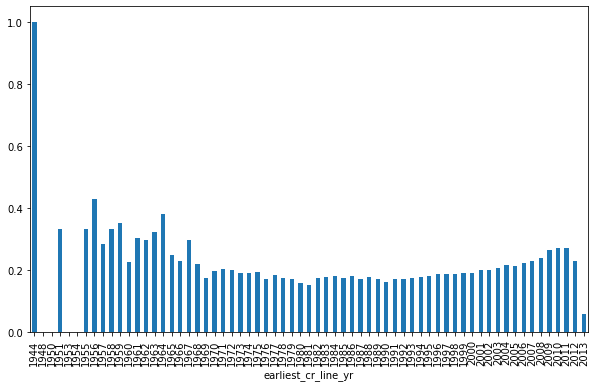

In [60]:
plt.figure(figsize=(10,6))
(unpaid_group / df.groupby('earliest_cr_line_yr').count()['loan_amnt']).plot(kind='bar')

In [61]:
df = df.drop('earliest_cr_line',axis=1)
df.head()

,loan_amnt,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,open_acc,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_paid,no_payments,earliest_cr_line_yr
0,10000.0,11.44,329.48,B4,RENT,117000.0,Not Verified,vacation,26.24,16.0,...,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1,36,1990
1,8000.0,11.99,265.68,B5,MORTGAGE,65000.0,Not Verified,debt_consolidation,22.05,17.0,...,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1,36,2004
2,15600.0,10.49,506.97,B3,RENT,43057.0,Source Verified,credit_card,12.79,13.0,...,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1,36,2007
3,7200.0,6.49,220.65,A2,RENT,54000.0,Not Verified,credit_card,2.60,6.0,...,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1,36,2006
4,24375.0,17.27,609.33,C5,MORTGAGE,55000.0,Verified,credit_card,33.95,13.0,...,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0,60,1999


Dealing with the missing data

In [62]:
df.isnull().sum()

loan_amnt                   0
int_rate                    0
installment                 0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
dti                         0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_paid                   0
no_payments                 0
earliest_cr_line_yr         0
dtype: int64

In [63]:
df = df.dropna(subset=['revol_util','pub_rec_bankruptcies'])

In [64]:
df.corr()['mort_acc'].sort_values(ascending=False)

mort_acc                1.000000
total_acc               0.381205
annual_inc              0.236277
loan_amnt               0.222381
revol_bal               0.195063
installment             0.193752
open_acc                0.109440
no_payments             0.096211
loan_paid               0.073048
pub_rec_bankruptcies    0.027273
pub_rec                 0.011576
revol_util              0.007514
dti                    -0.025401
int_rate               -0.082656
Name: mort_acc, dtype: float64

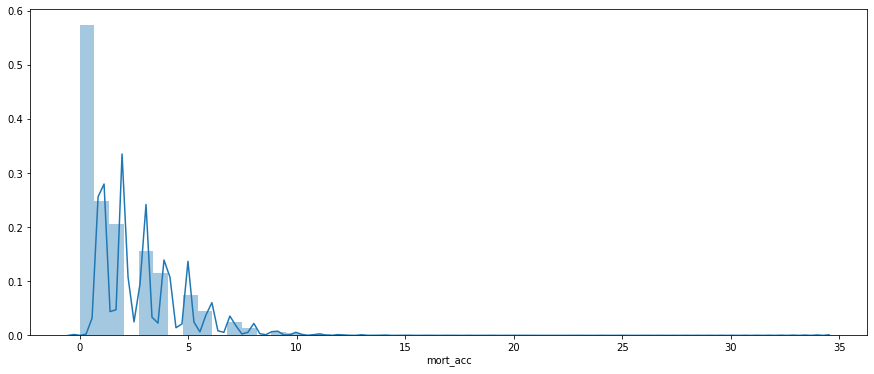

In [65]:
plt.figure(figsize=(15,6))
sns.distplot(df['mort_acc'])

In [66]:
len(df[df['mort_acc'].isnull()])

37205

In [67]:
grouped_mort_acc = df.groupby('total_acc').mean()['mort_acc']
grouped_mort_acc[:10]

total_acc
2.0     0.000000
3.0     0.052326
4.0     0.066743
5.0     0.102108
6.0     0.151123
7.0     0.221827
8.0     0.307414
9.0     0.364772
10.0    0.428702
Name: mort_acc, dtype: float64

In [68]:
# df.iloc[22]['mort_acc'] == df.iloc[22]['mort_acc']
def fill_mort_acc(x):
    if x['mort_acc'] != x['mort_acc']:
        return grouped_mort_acc[x['total_acc']]
    return x['mort_acc']

df['mort_acc'] = df.apply(fill_mort_acc, axis=1)

In [69]:
df.isnull().sum()

loan_amnt               0
int_rate                0
installment             0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
purpose                 0
dti                     0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_paid               0
no_payments             0
earliest_cr_line_yr     0
dtype: int64

In [70]:
df.head()

,loan_amnt,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,open_acc,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_paid,no_payments,earliest_cr_line_yr
0,10000.0,11.44,329.48,B4,RENT,117000.0,Not Verified,vacation,26.24,16.0,...,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1,36,1990
1,8000.0,11.99,265.68,B5,MORTGAGE,65000.0,Not Verified,debt_consolidation,22.05,17.0,...,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1,36,2004
2,15600.0,10.49,506.97,B3,RENT,43057.0,Source Verified,credit_card,12.79,13.0,...,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1,36,2007
3,7200.0,6.49,220.65,A2,RENT,54000.0,Not Verified,credit_card,2.60,6.0,...,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1,36,2006
4,24375.0,17.27,609.33,C5,MORTGAGE,55000.0,Verified,credit_card,33.95,13.0,...,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0,60,1999


In [71]:
info('initial_list_status')

The initial listing status of the loan. Possible values are – W, F


In [72]:
df['initial_list_status'].value_counts()

f    237346
w    157873
Name: initial_list_status, dtype: int64

In [73]:
df['initial_list_status'] = df['initial_list_status'].map({ 'f':0,'w':1 })

In [74]:
df['address']

0              0174 Michelle Gateway\nMendozaberg, OK 22690
1           1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2           87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3                     823 Reid Ford\nDelacruzside, MA 00813
4                      679 Luna Roads\nGreggshire, VA 11650
                                ...                        
396025       12951 Williams Crossing\nJohnnyville, DC 30723
396026    0114 Fowler Field Suite 028\nRachelborough, LA...
396027     953 Matthew Points Suite 414\nReedfort, NY 70466
396028    7843 Blake Freeway Apt. 229\nNew Michael, FL 2...
396029          787 Michelle Causeway\nBriannaton, AR 48052
Name: address, Length: 395219, dtype: object

In [75]:
address_info = df['address'].apply(lambda x: x.split(' ')[-2])
address_info2 = df['address'].apply(lambda x: x.split(' ')[-1])

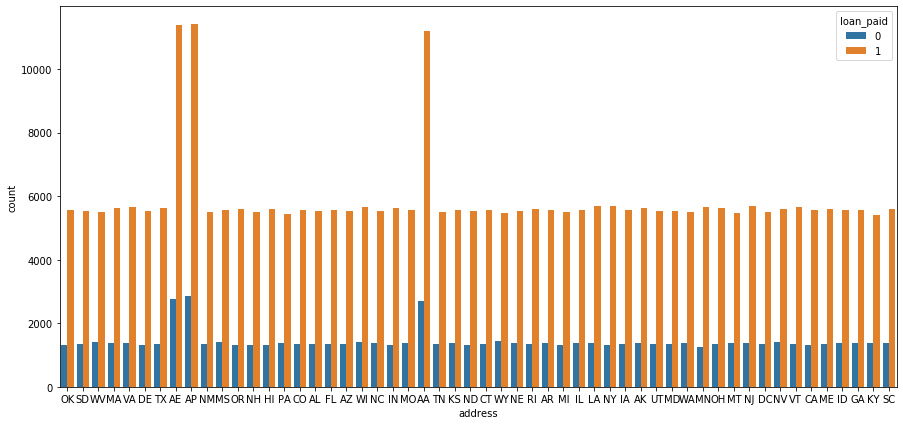

In [76]:
plt.figure(figsize=(15,7))
sns.countplot(address_info, hue=df['loan_paid'])

In [77]:
address_info.nunique()

54

It seems like we are not gaining much information. And there would be too many dumb variables

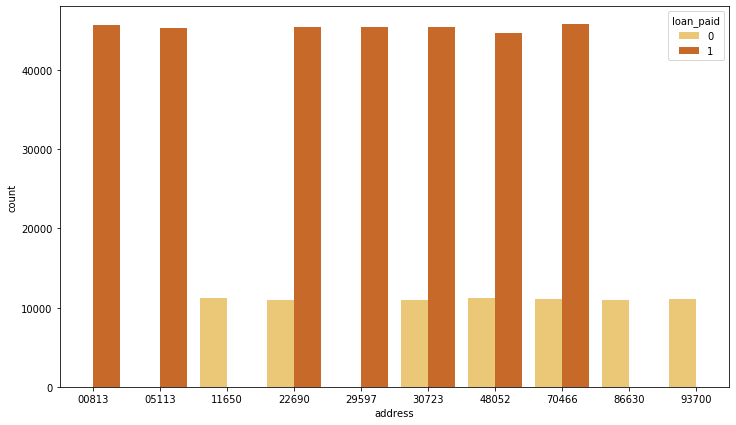

In [78]:
plt.figure(figsize=(12,7))
sns.countplot(address_info2, hue=df['loan_paid'], palette="YlOrBr")

ZIP code on the other hand seems more useful

In [79]:
address_info2.value_counts()

70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: address, dtype: int64

In [80]:
df['zip_code'] = address_info2
df = df.drop('address', axis=1)
df.head()

,loan_amnt,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,open_acc,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_paid,no_payments,earliest_cr_line_yr,zip_code
0,10000.0,11.44,329.48,B4,RENT,117000.0,Not Verified,vacation,26.24,16.0,...,41.8,25.0,1,INDIVIDUAL,0.0,0.0,1,36,1990,22690
1,8000.0,11.99,265.68,B5,MORTGAGE,65000.0,Not Verified,debt_consolidation,22.05,17.0,...,53.3,27.0,0,INDIVIDUAL,3.0,0.0,1,36,2004,05113
2,15600.0,10.49,506.97,B3,RENT,43057.0,Source Verified,credit_card,12.79,13.0,...,92.2,26.0,0,INDIVIDUAL,0.0,0.0,1,36,2007,05113
3,7200.0,6.49,220.65,A2,RENT,54000.0,Not Verified,credit_card,2.60,6.0,...,21.5,13.0,0,INDIVIDUAL,0.0,0.0,1,36,2006,00813
4,24375.0,17.27,609.33,C5,MORTGAGE,55000.0,Verified,credit_card,33.95,13.0,...,69.8,43.0,0,INDIVIDUAL,1.0,0.0,0,60,1999,11650


In [81]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'sub_grade', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_paid', 'no_payments',
       'earliest_cr_line_yr', 'zip_code'],
      dtype='object')

**Our final table will be looking like this:**

In [82]:
df = pd.get_dummies(df, columns=['sub_grade','home_ownership','verification_status','purpose','application_type','zip_code'], drop_first=True)
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,application_type_JOINT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.0,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,...,0,0,0,1,0,0,0,0,0,0
1,8000.0,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,...,0,1,0,0,0,0,0,0,0,0
2,15600.0,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,...,0,1,0,0,0,0,0,0,0,0
3,7200.0,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,...,0,0,0,0,0,0,0,0,0,0
4,24375.0,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,43.0,...,0,0,1,0,0,0,0,0,0,0


### Neural Network

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X = df.drop('loan_paid',axis=1)
y = df['loan_paid']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [86]:
from tensorflow.keras.callbacks import EarlyStopping

In [87]:
stop = EarlyStopping(monitor='val_loss',patience=15,mode='min',verbose=1)

In [88]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [89]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [91]:
X_train.shape

(276653, 78)

In [92]:
model = Sequential()

model.add(Dense(units=78,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=40,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=20,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [93]:
model.fit(x=X_train,y=y_train,epochs=15,callbacks=[stop],validation_data=(X_test,y_test),verbose=1)

Epoch 1/15
8646/8646 [==============================] - 40s 5ms/step - loss: 0.3525 - accuracy: 0.8535 - val_loss: 0.2677 - val_accuracy: 0.8877
Epoch 2/15
8646/8646 [==============================] - 38s 4ms/step - loss: 0.2856 - accuracy: 0.8848 - val_loss: 0.2655 - val_accuracy: 0.8877
Epoch 3/15
8646/8646 [==============================] - 39s 4ms/step - loss: 0.2811 - accuracy: 0.8853 - val_loss: 0.2650 - val_accuracy: 0.8877
Epoch 4/15
8646/8646 [==============================] - 40s 5ms/step - loss: 0.2800 - accuracy: 0.8853 - val_loss: 0.2655 - val_accuracy: 0.8877
Epoch 5/15
8646/8646 [==============================] - 37s 4ms/step - loss: 0.2792 - accuracy: 0.8857 - val_loss: 0.2653 - val_accuracy: 0.8877
Epoch 6/15
8646/8646 [==============================] - 39s 5ms/step - loss: 0.2821 - accuracy: 0.8856 - val_loss: 0.2644 - val_accuracy: 0.8877
Epoch 7/15
8646/8646 [==============================] - 39s 5ms/step - loss: 0.2786 - accuracy: 0.8855 - val_loss: 0.2652 - val_ac

In [94]:
details = pd.DataFrame(model.history.history)
details

,loss,accuracy,val_loss,val_accuracy
0,0.352510,0.853546,0.267747,0.887733
1,0.285589,0.884758,0.265499,0.887733
2,0.281113,0.885340,0.264984,0.887733
3,0.279970,0.885279,0.265484,0.887733
4,0.279204,0.885673,0.265316,0.887733
5,0.282132,0.885593,0.264355,0.887733
6,0.278560,0.885474,0.265231,0.887733
7,0.280114,0.885553,0.265353,0.887733
8,0.277772,0.885297,0.264966,0.887733
9,0.277883,0.885394,0.264845,0.887733


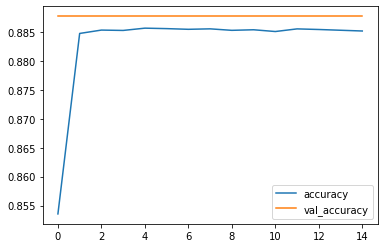

In [95]:
details[['accuracy','val_accuracy']].plot()

In [96]:
from sklearn.metrics import classification_report, confusion_matrix

In [97]:
predictions = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [98]:
predictions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [99]:
# Unbalanced database
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.43      0.60     23244
           1       0.88      1.00      0.93     95322

    accuracy                           0.89    118566
   macro avg       0.94      0.71      0.77    118566
weighted avg       0.90      0.89      0.87    118566



In [100]:
# Misclassifying 0 points?
print(confusion_matrix(y_test,predictions))

[[ 9933 13311]
 [    0 95322]]


In [101]:
df['loan_paid'].value_counts()

1    317696
0     77523
Name: loan_paid, dtype: int64

In [102]:
#paid / len(df)

***Now given a customer, would you offer him a loan?***

In [103]:
random_id = np.random.randint(0,len(df))

new_customer = df.drop('loan_paid',axis=1).iloc[random_id]
new_customer

loan_amnt          10000
int_rate           14.16
installment       233.52
annual_inc         35000
dti                16.63
                   ...  
zip_code_30723         0
zip_code_48052         1
zip_code_70466         0
zip_code_86630         0
zip_code_93700         0
Name: 288181, Length: 78, dtype: object

In [104]:
# change pd Series into np array; adds the extra square brackets
new_customer.values.reshape(1,78)

array([[10000.0, 14.16, 233.52, 35000.0, 16.63, 5.0, 0.0, 9577.0, 94.8,
        15.0, 0, 0.0, 0.0, 60, '2005', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0]], dtype=object)

In [105]:
new_customer = scaler.transform(new_customer.values.reshape(1,78))

In [106]:
model.predict_classes(new_customer)

array([[1]])

In [107]:
 df.iloc[random_id]['loan_paid']

1